In [1]:
import os
import pandas as pd
import scipy.io as sio
import numpy as np
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
def get_file(record_base_path):
    files = []
    for filename in os.listdir(record_base_path):
        if filename.endswith('.mat'):
            path = os.path.join(record_base_path, filename)
            files.append(path)
    return files

In [3]:
def get_data(path):
    min_batch = []    
    for i in tqdm(range(len(get_file(record_base_path)))):
        data_12 = sio.loadmat(path[i])['ECG'][0][0][2]
        jieduan = data_12[:,i:i+3000]
        if jieduan.shape[1] <3000:
            jieduan = data_12[:,-3000:]
        min_batch.append(jieduan[[1,2,6,7,8,9,10,11],:].T) 
    return np.array(min_batch).reshape(-1,3000,8)

In [4]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    fig = plt.figure(figsize=(16,10))
    
    ## Loss
    fig.add_subplot(2,1,1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    fig.add_subplot(2,1,2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('training_history.png')
    plt.show()    

In [5]:
record_base_path = "./CPSC2018"
filemat = get_file(record_base_path)
X = get_data(filemat)
df = pd.read_csv('./CPSC2018/REFERENCE.csv')
y = pd.get_dummies(df["First_label"][:X.shape[0]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

100%|█████████████████████████████████████████████████████████████████████████████| 6877/6877 [00:22<00:00, 302.80it/s]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2995, 64)          3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 2995, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1498, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1498, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1496, 64)          12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1496, 64)          256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 748, 64)           0

Epoch 41/60
65/65 [==============================] - 34s 527ms/step - loss: 0.0894 - accuracy: 0.9679 - val_loss: 8.4169 - val_accuracy: 0.3721
Epoch 42/60
65/65 [==============================] - 34s 528ms/step - loss: 0.1050 - accuracy: 0.9656 - val_loss: 7.2344 - val_accuracy: 0.3837
Epoch 43/60
65/65 [==============================] - 34s 522ms/step - loss: 0.0999 - accuracy: 0.9663 - val_loss: 8.1262 - val_accuracy: 0.3699
Epoch 44/60
65/65 [==============================] - 34s 528ms/step - loss: 0.0897 - accuracy: 0.9724 - val_loss: 6.6206 - val_accuracy: 0.3961
Epoch 45/60
65/65 [==============================] - 34s 525ms/step - loss: 0.0966 - accuracy: 0.9665 - val_loss: 7.5714 - val_accuracy: 0.3801
Epoch 46/60
65/65 [==============================] - 34s 526ms/step - loss: 0.0827 - accuracy: 0.9704 - val_loss: 6.9374 - val_accuracy: 0.3866
Epoch 47/60
65/65 [==============================] - 34s 527ms/step - loss: 0.0834 - accuracy: 0.9707 - val_loss: 7.6754 - val_accuracy:

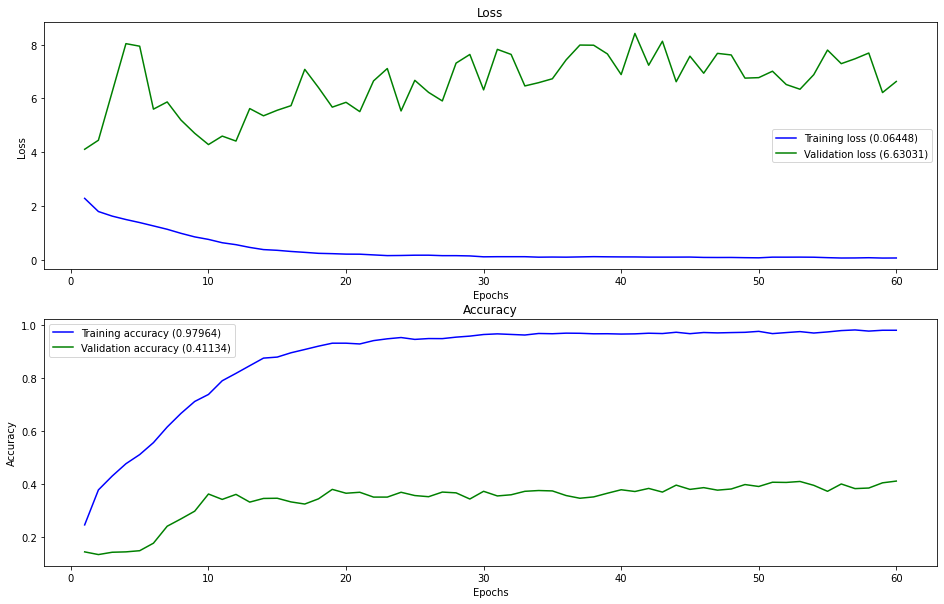

In [6]:
sec_path = r'./results/'

EPOCHS = 60
BATCH_SIZE = 64

num_classes = y_train.shape[1]
input_size = X_train.shape[1], X_train.shape[2]

model = models.Sequential()

model.add(layers.Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(input_size)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=(3), strides=(2), padding="same"))
model.add(layers.Dropout(0.5))

model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=(2), strides=(2), padding="same"))
model.add(layers.Dropout(0.5))

model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=(2), strides=(2), padding="same"))
model.add(layers.Dropout(0.5))

#LSTM model
#model.add(layers.LSTM(64, return_sequences=True))
#model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(y_train.shape[1], activation='softmax'))

print(model.summary())

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

start_time = time.time()

model_checkpoint_callback = ModelCheckpoint(sec_path + 'weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                      validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

elapsed_time = time.time() - start_time # training time

loss, accuracy = model.evaluate(X_test, y_test) # evaluating model on test data

plot_history(history)


loss = float("{0:.3f}".format(loss))
accuracy = float("{0:.3f}".format(accuracy))
elapsed_time = float("{0:.3f}".format(elapsed_time))


#saving model
hist_df = pd.DataFrame(history.history) 
result = ["Evaluation result: ","loss: "+ str(loss), "accuracy: "+ str(accuracy), "elapsed_time: "+ str(elapsed_time)]
result = pd.DataFrame(result)
with open(sec_path + 'history.csv', mode='w') as f:
    result.to_csv(f)
    hist_df.to_csv(f)

In [7]:
encoder = model.load_weights(sec_path + "weight.hdf5")
encoded_data = model.predict(X_test)

#mpl.rcParams['figure.figsize'] = [12, 8]
#fig, ax = plt.subplots()
#ax.plot(encoded_data)